## Introduction
From Kaggle open resource, we had **training** dataset, **public test** dataset (which is then used as validation dataset for our project), and further a **private test** dataset (same size with public test dataset and will be used as data for evaluating the prediction performance).

Image set of 35,887 examples, with training-set : **80%** validation-set : **10%** test-set : **10%**.

## Objectives
(i) To apply Convolutional neural networks (CNN) for facial expression recognition.
 
(ii) To correctly classify each facial image into one of the seven facial emotion categories: **anger**, **disgust**, **fear**, **happiness**, **sadness**, **surprise**, and **neutral**.


---------------------------------------------------------------------------------------
## Import libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries inst

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import os

#required libraries
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121





In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Dataset Overview

In [3]:
data = pd.read_csv('/content/drive/My Drive/data/fer2013/fer2013.csv')
#check data shape
data.shape

(35887, 3)

In [4]:
#preview first 5 row of data
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
#check usage values
#80% training, 10% validation and 10% test
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [6]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


#### Let's look at some images...

<ipython-input-7-483c62a7888b>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([image.astype(np.uint8), emotion])


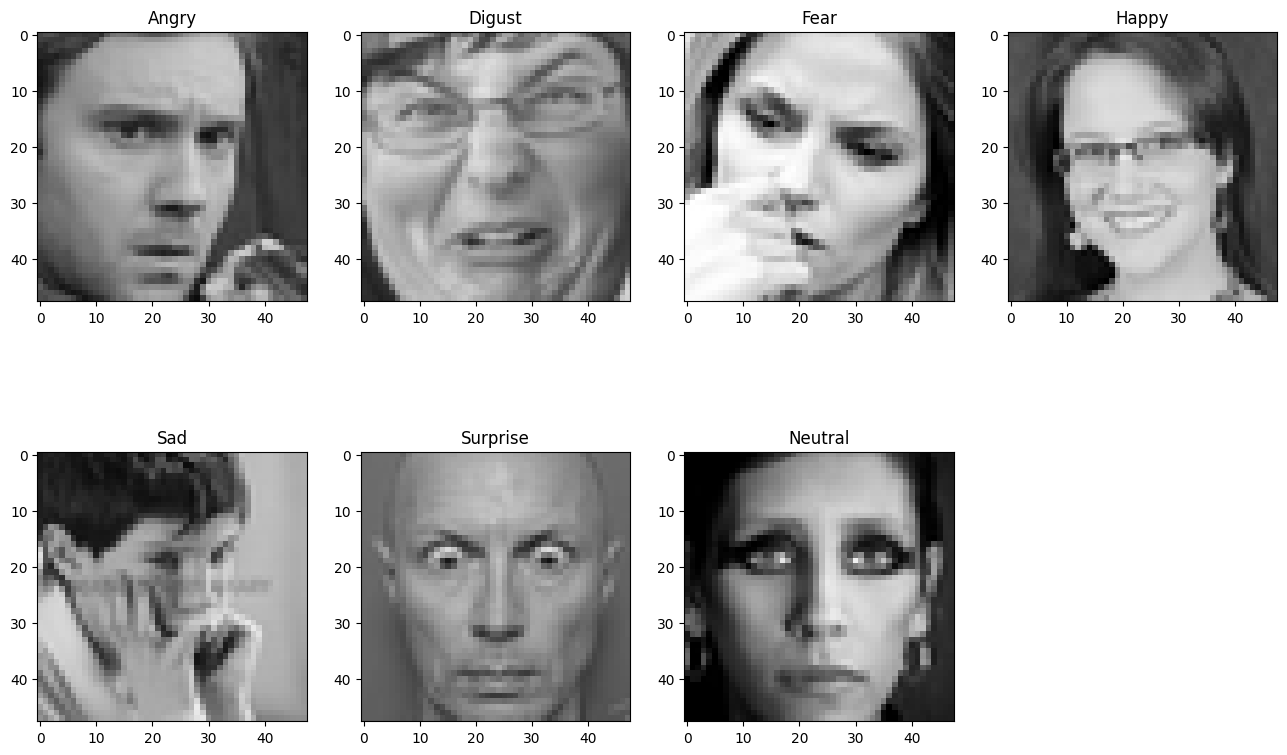

In [7]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()  

----------------------------------------------------------------------------------
## Pre-processing data
#### Summary:
1. Splitting dataset into 3 parts: train, validation, test
1. Convert strings to lists of integers
1. Reshape to 48x48 and normalise grayscale image with 255.0
1. Perform one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

In [8]:
#split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


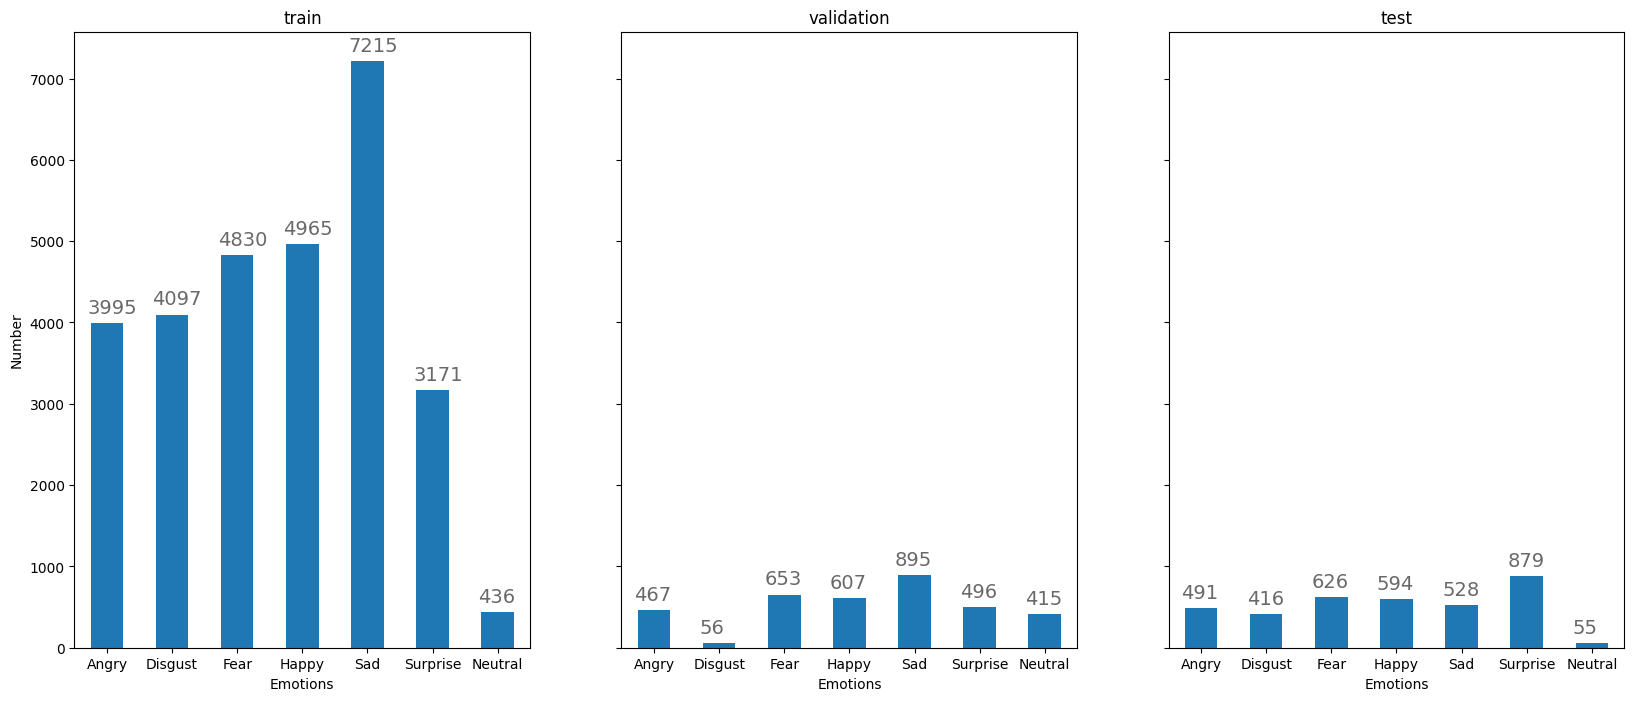

In [9]:
# barplot class distribution of train, val and test
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

   
fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

Notice that the later two subplots share the same y-axis with the first subplot. 

The size of **train**, **validation**, **test** are **80%**, **10%** and **10%**, respectively. 

The exact number of each class of these datasets are written on top of their x-axis bar. 

In [10]:
#initilize parameters
num_classes = 7 
width, height = 48, 48
batch_size = 64
num_features = 64

In [11]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


----------------------------------------------------------------------------------
## Building CNN Model



In [12]:
from keras.layers import Input, Dense, GlobalAveragePooling2D, Lambda
from keras.models import Model
from keras.applications.resnet import ResNet101, preprocess_input
import tensorflow as tf

# Define input shape
input_shape = (48, 48, 1)

# Load pre-trained ResNet101 model
base_model = ResNet101(input_shape=(input_shape[0], input_shape[1], 3), include_top=False, weights='imagenet')

# Add a lambda layer to convert grayscale to RGB
def gray2rgb(x):
    return tf.image.grayscale_to_rgb(x)

input_layer = Input(shape=input_shape)
rgb_layer = Lambda(gray2rgb)(input_layer)
    
# Add global average pooling layer
x = base_model(rgb_layer)
x = GlobalAveragePooling2D()(x)

# Add output layer with softmax activation for multi-class classification
num_classes = 7 # 7 emotions to classify
predictions = Dense(num_classes, activation='softmax')(x)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create model object
model = Model(inputs=input_layer, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


171446536/171446536 [==============================] - 1s 0us/step


In [13]:

# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

history = model.fit(train_X, train_Y, batch_size,
                                epochs=20,
                                validation_data=(val_X, val_Y))

Epoch 1/20
449/449 [==============================] - 617s 1s/step - loss: 1.8053 - accuracy: 0.2524 - val_loss: 1.7861 - val_accuracy: 0.2753
Epoch 2/20
449/449 [==============================] - 606s 1s/step - loss: 1.7829 - accuracy: 0.2634 - val_loss: 1.7715 - val_accuracy: 0.2744
Epoch 3/20
449/449 [==============================] - 582s 1s/step - loss: 1.7686 - accuracy: 0.2756 - val_loss: 1.7631 - val_accuracy: 0.2744
Epoch 4/20
449/449 [==============================] - 600s 1s/step - loss: 1.7594 - accuracy: 0.2785 - val_loss: 1.7467 - val_accuracy: 0.2984
Epoch 5/20
449/449 [==============================] - 602s 1s/step - loss: 1.7495 - accuracy: 0.2869 - val_loss: 1.7527 - val_accuracy: 0.2884
Epoch 6/20
449/449 [==============================] - 601s 1s/step - loss: 1.7421 - accuracy: 0.2937 - val_loss: 1.7464 - val_accuracy: 0.2965
Epoch 7/20
449/449 [==============================] - 607s 1s/step - loss: 1.7372 - accuracy: 0.2966 - val_loss: 1.7326 - val_accuracy: 0.3073

## Visualize Training Performance

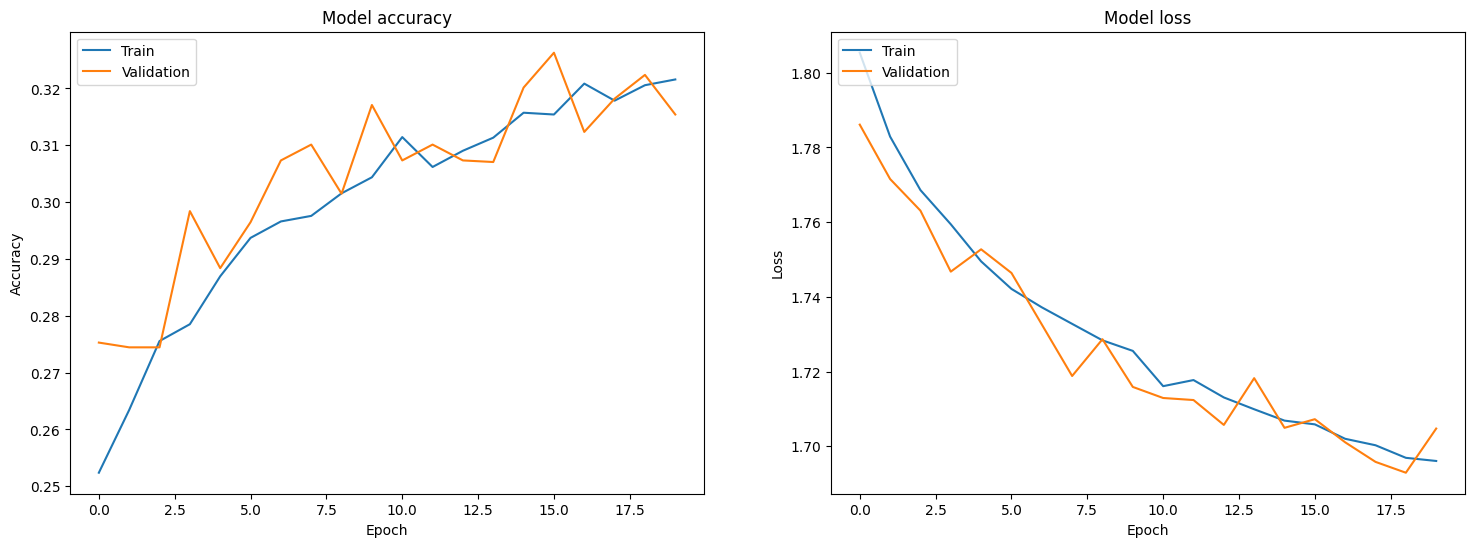

In [14]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Evaluate Test Performance

In [15]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print(test_true,test_pred)

113/113 [==============================] - 67s 575ms/step
[0 5 6 ... 0 3 2] [3 3 2 ... 3 3 3]


## More Analysis using Confusion Matrix

Confusion Matrix is applied and plotted to find out which emotion usually get confused with each other.

In [16]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

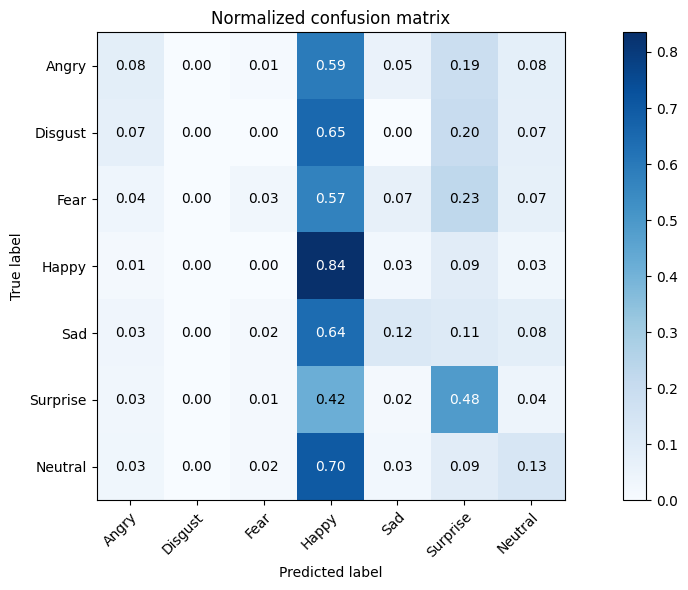

In [17]:
# Plot normalized confusion matrix
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()